# みはらのけんきゅー

In [1]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## モジュールを環境にインストール

In [2]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 10.4 MB/s eta 0:00:00


In [3]:
!pip uninstall pandas_profiling
#!pip install -U pandas_profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2719, in key
    return self._key
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _key. Did you mean: 'key'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_comm

## データの作成

### ライブラリのインポート

In [4]:
#モジュールの読み込み
from __future__ import print_function

import pandas as pd
from pandas import Series,DataFrame

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import seaborn as sns

import time

#import pandas_profiling as pdp

### エクセルデータを編集

In [5]:
df = pd.read_excel('drive/MyDrive/見原/Data/general_data_openstack_bugs-2021-06-27.xlsx')

In [6]:
df['Opened'] = pd.to_datetime(df['Opened'], format='%Y-%m-%d %H:%M:%S')
df['Changed'] = pd.to_datetime(df['Changed'], format='%Y-%m-%d %H:%M:%S')
df.head(3)

,Bug ID,Opened,Unnamed: 2,Changed,Unnamed: 4,Reporter,Unnamed: 6,Assignee,Unnamed: 8,Product,...,OS,Unnamed: 20,Severity,Unnamed: 22,Version,Unnamed: 24,Summary,Unnamed: 26,output,hour
0,856263,2012-09-11 15:03:44,NaN,2016-04-26 22:17:15,NaN,Daniel Berrangﾃｩ,0.00125,Daniel Berrangﾃｩ,0.001526,Red Hat OpenStack,...,Unspecified,0.753589,unspecified,0.166009,2.0 (Folsom),0.019299,Fix libvirt auth callback to allow for use of ...,78,NaN,0.000000
1,861492,2012-09-28 19:53:40,17.201343,2016-04-22 05:01:41,0.0,Dan Yocum,0.00288,Nikola Dipanov,0.005721,Red Hat OpenStack,...,Linux,0.218226,unspecified,0.166009,1.0 (Essex),0.002524,live migration fails to migrate iptable rules ...,57,17.201343,412.832222
2,861516,2012-09-28 21:53:40,0.083333,2013-07-04 02:51:13,0.0,Dan Yocum,0.00288,RHOS Maint,0.095075,Red Hat OpenStack,...,Unspecified,0.753589,unspecified,0.166009,1.0 (Essex),0.002524,compute_nodes not being properly updated,40,0.083333,2.000000


In [7]:
df_2 = pd.DataFrame(df[["Bug ID","Opened","Changed","Reporter",
                       "Assignee","Product","Component","Status",
                       "Resolution","Hardware","OS","Severity",
                       "Version","Summary"
                       ]])
print("\n\n")
print(df_2.info())
print("\n\n")
print("欠損の確認")
print(df_2.isna().sum())
#後にラベルエンコーディングをするとき、0から数字が降られるので、欠損補完
df_2[["Reporter","Assignee"]] = df_2[["Reporter","Assignee"]].fillna("Unknown", inplace=False)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19017 entries, 0 to 19016
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Bug ID      19017 non-null  int64         
 1   Opened      19017 non-null  datetime64[ns]
 2   Changed     19017 non-null  datetime64[ns]
 3   Reporter    18401 non-null  object        
 4   Assignee    18354 non-null  object        
 5   Product     19017 non-null  object        
 6   Component   19017 non-null  object        
 7   Status      19017 non-null  object        
 8   Resolution  19017 non-null  object        
 9   Hardware    19017 non-null  object        
 10  OS          19017 non-null  object        
 11  Severity    19017 non-null  object        
 12  Version     19017 non-null  object        
 13  Summary     19017 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 2.0+ MB
None



欠損の確認
Bug ID          0
Opened          0


In [8]:
# Openedを日付順に変更
df_3 = df_2.sort_values('Opened')
df_3.head()

,Bug ID,Opened,Changed,Reporter,Assignee,Product,Component,Status,Resolution,Hardware,OS,Severity,Version,Summary
17416,833398,2012-06-19 12:13:14,2019-09-09 16:04:58,David Naori,Xavier Queralt,Red Hat OpenStack,openstack-nova,CLOSED,UPSTREAM,Unspecified,Unspecified,low,1.0 (Essex),[RFE][nova][preformance] qemu-img info command...
2940,835466,2012-06-26 09:27:15,2013-07-04 02:47:20,David Naori,Alan Pevec,Red Hat OpenStack,openstack-nova,CLOSED,CURRENTRELEASE,x86_64,Linux,high,1.0 (Essex),[nova] injection of ssh authorized_keys someti...
13444,842136,2012-07-22 13:41:36,2019-09-09 16:10:30,David Naori,Brent Eagles,Red Hat OpenStack,openstack-nova,CLOSED,ERRATA,Unspecified,Unspecified,medium,1.0 (Essex),[nova][RFE][Resize|Migrate][preformance] avoid...
8029,847785,2012-08-13 14:36:41,2016-04-26 17:07:08,Gary Kotton,Alan Pevec,Red Hat OpenStack,openstack-quantum,CLOSED,ERRATA,Unspecified,Unspecified,high,1.0 (Essex),Quantum installation scripts for linux bridge ...
13445,856149,2012-09-11 10:20:48,2016-04-26 16:18:01,Daniel Berrangﾃｩ,RHOS Maint,Red Hat OpenStack,openstack-quantum,CLOSED,CURRENTRELEASE,Unspecified,Unspecified,medium,2.0 (Folsom),Need to provide a formal API for Nova to use t...


In [9]:
# 値がすべて同じカラムは削除
unique_counts = df_3.nunique()
same_value_columns = unique_counts[unique_counts == 1].index.tolist()
df_4 = df_3.drop(same_value_columns, axis=1)
df_4.head()

,Bug ID,Opened,Changed,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,Summary
17416,833398,2012-06-19 12:13:14,2019-09-09 16:04:58,David Naori,Xavier Queralt,openstack-nova,UPSTREAM,Unspecified,Unspecified,low,1.0 (Essex),[RFE][nova][preformance] qemu-img info command...
2940,835466,2012-06-26 09:27:15,2013-07-04 02:47:20,David Naori,Alan Pevec,openstack-nova,CURRENTRELEASE,x86_64,Linux,high,1.0 (Essex),[nova] injection of ssh authorized_keys someti...
13444,842136,2012-07-22 13:41:36,2019-09-09 16:10:30,David Naori,Brent Eagles,openstack-nova,ERRATA,Unspecified,Unspecified,medium,1.0 (Essex),[nova][RFE][Resize|Migrate][preformance] avoid...
8029,847785,2012-08-13 14:36:41,2016-04-26 17:07:08,Gary Kotton,Alan Pevec,openstack-quantum,ERRATA,Unspecified,Unspecified,high,1.0 (Essex),Quantum installation scripts for linux bridge ...
13445,856149,2012-09-11 10:20:48,2016-04-26 16:18:01,Daniel Berrangﾃｩ,RHOS Maint,openstack-quantum,CURRENTRELEASE,Unspecified,Unspecified,medium,2.0 (Folsom),Need to provide a formal API for Nova to use t...


In [10]:
#"TBF"は"Time Between Failures"（故障時間）
#"TTR"は"Time To Repair"       （修正時間）

df_4["TBF"] = (df_4['Changed'] - df_4['Opened']).dt.days #日数
df_4["TBF_2"] = (df_4['Changed'] - df_4['Opened']).dt.components['hours'] + df_4["TBF"]*24 #時間
df_4["TTR"] = (df_4['Opened'] - df_4['Opened'].shift(1)).dt.days #日数
df_4["TTR_2"] = (df_4['Opened'] - df_4['Opened'].shift(1)).dt.components['hours'] + df_4["TTR"]*24 #時間
df_4['days'] = df_4['Opened'].dt.day
df_4['month'] = df_4['Opened'].dt.month
df_4['year'] = df_4['Opened'].dt.year

#データの整理
df_4 = df_4.drop(17416)
# インデックスがぐちゃぐちゃだから戻した
df_4 = df_4.reset_index(drop = True)
df_4.head(3)


,Bug ID,Opened,Changed,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,Summary,TBF,TBF_2,TTR,TTR_2,days,month,year
0,835466,2012-06-26 09:27:15,2013-07-04 02:47:20,David Naori,Alan Pevec,openstack-nova,CURRENTRELEASE,x86_64,Linux,high,1.0 (Essex),[nova] injection of ssh authorized_keys someti...,372,8945,6.0,165.0,26,6,2012
1,842136,2012-07-22 13:41:36,2019-09-09 16:10:30,David Naori,Brent Eagles,openstack-nova,ERRATA,Unspecified,Unspecified,medium,1.0 (Essex),[nova][RFE][Resize|Migrate][preformance] avoid...,2605,62522,26.0,628.0,22,7,2012
2,847785,2012-08-13 14:36:41,2016-04-26 17:07:08,Gary Kotton,Alan Pevec,openstack-quantum,ERRATA,Unspecified,Unspecified,high,1.0 (Essex),Quantum installation scripts for linux bridge ...,1352,32450,22.0,528.0,13,8,2012


In [11]:
# "Opened"をインデックスにセットして、データに曜日情報を追加
df_5 = df_4.set_index(['Opened'])
df_5['Weekday'] = df_5.index.strftime('%A')
df_5.head(3)

,Bug ID,Changed,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,Summary,TBF,TBF_2,TTR,TTR_2,days,month,year,Weekday
Opened,,,,,,,,,,,,,,,,,,,
2012-06-26 09:27:15,835466,2013-07-04 02:47:20,David Naori,Alan Pevec,openstack-nova,CURRENTRELEASE,x86_64,Linux,high,1.0 (Essex),[nova] injection of ssh authorized_keys someti...,372,8945,6.0,165.0,26,6,2012,Tuesday
2012-07-22 13:41:36,842136,2019-09-09 16:10:30,David Naori,Brent Eagles,openstack-nova,ERRATA,Unspecified,Unspecified,medium,1.0 (Essex),[nova][RFE][Resize|Migrate][preformance] avoid...,2605,62522,26.0,628.0,22,7,2012,Sunday
2012-08-13 14:36:41,847785,2016-04-26 17:07:08,Gary Kotton,Alan Pevec,openstack-quantum,ERRATA,Unspecified,Unspecified,high,1.0 (Essex),Quantum installation scripts for linux bridge ...,1352,32450,22.0,528.0,13,8,2012,Monday


In [12]:
# ラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
encoding_column = ["Reporter","Assignee","Component","Resolution",
                  "Hardware","OS","Severity","Version","Weekday"
                  ]
for column in encoding_column:
    df_5[column] = LabelEncoder().fit_transform(df_5[column].astype(str))

df_5.tail(3)

,Bug ID,Changed,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,Summary,TBF,TBF_2,TTR,TTR_2,days,month,year,Weekday
Opened,,,,,,,,,,,,,,,,,,,
2021-06-18 10:53:34,1973635,2021-06-18 12:26:38,952,328,32,3,6,1,2,8,Post Live-migration tasks fail and leave nova....,0,1,1.0,26.0,18,6,2021,0
2021-06-21 06:28:11,1974195,2021-06-23 15:58:08,865,187,32,3,0,1,0,4,[OSP 18] Live migration rollback after failure...,2,57,2.0,67.0,21,6,2021,1
2021-06-22 16:29:20,1974856,2021-06-22 21:21:55,600,328,32,8,6,1,0,4,[OSP 13] - live migration failures,0,4,1.0,34.0,22,6,2021,5


In [ ]:
# 欠損の確認
print("Nanの補完")
print(df_5.isna().sum())

Nanの補完
Bug ID        0
Changed       0
Reporter      0
Assignee      0
Component     0
Resolution    0
Hardware      0
OS            0
Severity      0
Version       0
Summary       0
TBF           0
TBF_2         0
TTR           0
TTR_2         0
days          0
month         0
year          0
Weekday       0
dtype: int64


In [13]:
from tsfresh import extract_features

features = extract_features(df_5[["TBF","TTR"]], column_id="TBF")
features

Feature Extraction:   3%|▎         | 74/2143 [00:05<02:37, 13.17it/s]


KeyboardInterrupt: ignored

In [ ]:
extracted_features = pd.concat([features, df_4[["TBF","TTR"]]], axis=1)
extracted_features[["TBF"]].head(3)

,TBF
0,372
1,2605
2,1352


In [14]:
#ランダムシード固定
from sklearn.utils import check_random_state
import random
seed = 13
random_state = check_random_state(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
extracted_features = extracted_features.replace([np.inf, -np.inf], np.nan)

In [ ]:
extracted_features =  extracted_features.fillna(0)

In [ ]:
extracted_features = extracted_features.astype(np.float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# データのスケーリング
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(extracted_features)

# スケーリング後のデータをデータフレームに変換
scaled_df = pd.DataFrame(scaled_data, columns=extracted_features.columns)

# データのクリーニング
imputer = SimpleImputer(strategy='mean')  # 欠損値を平均値で補完する場合
cleaned_data = imputer.fit_transform(scaled_df)

# クリーニング後のデータをデータフレームに変換
cleaned_df = pd.DataFrame(cleaned_data, columns=scaled_df.columns)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(random_state=random_state)

#説明変数
x = pd.DataFrame(extracted_features.drop(["TBF"],axis=1))# .drop(["hogehoge"]で、"hogehoge"をドロップしてる

#目的変数
y = pd.DataFrame(extracted_features["TBF"])# ["hogehoge"]のカラムを"y"に代入

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1, shuffle=False, random_state=random_state)

RF_model.fit(x_train, y_train)
importances = RF_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 10  # 上位N個の特徴量を選択する例
selected_features = x_train.columns[indices][:top_n]

<ipython-input-699-ef21d6999c2e>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(x_train, y_train)


<ipython-input-763-d30938a23767>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


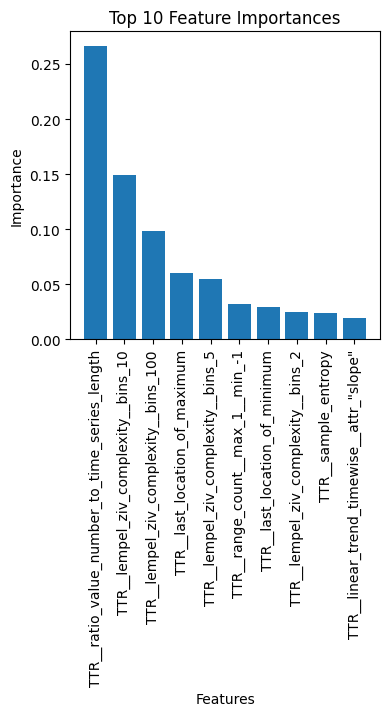

In [ ]:
# 上位N個の特徴量の重要度と特徴量名を取得
top_n = 10
top_features = x_train.columns[indices][:top_n]
top_importances = importances[indices][:top_n]

# 縦長の棒グラフで重要度を可視化（重要度の大きい順）
plt.figure(figsize=(4, 4))
plt.bar(range(top_n), top_importances[::1])
plt.xticks(range(top_n), top_features[::1], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top {} Feature Importances'.format(top_n))
plt.tight_layout()
plt.show()


TTR__ratio_value_number_to_time_series_length: タイプ数（異なる値の数）を、時系列データの長さで割ったものの比率を表します。

TTR__lempel_ziv_complexity__bins_10: データを10個のビンに分割し、各ビン内でのLempel-Ziv複雑度（圧縮アルゴリズムに基づく複雑度）を表します。

TTR__lempel_ziv_complexity__bins_100: データを100個のビンに分割し、各ビン内でのLempel-Ziv複雑度を表します。

TTR__last_location_of_maximum: 最大値の最後の出現位置を表します。

TTR__lempel_ziv_complexity__bins_5: データを5個のビンに分割し、各ビン内でのLempel-Ziv複雑度を表します。

TTR__range_count__max_1__min_-1: データの範囲（最大値と最小値の差）が1未満の要素の数を表します。

TTR__last_location_of_minimum: 最小値の最後の出現位置を表します。

TTR__lempel_ziv_complexity__bins_2: データを2個のビンに分割し、各ビン内でのLempel-Ziv複雑度を表します。

TTR__sample_entropy: サンプルエントロピーと呼ばれる指標で、データの予測不能性や乱雑さを測定します。

TTR__linear_trend_timewise__attr_"slope": 時系列データにおける線形トレンドの傾きを表します。

### CSVの場合

In [ ]:
#CSVファイルの読み込み
data_set = pd.read_csv("drive/MyDrive/見原/general_data.csv",sep=",",header=0)

### 最終的なデータセットの完成

In [15]:
data_set = pd.DataFrame(df_5.drop(["Changed","Summary"],axis=1))

## データの分析（特徴量エンジニアリング）

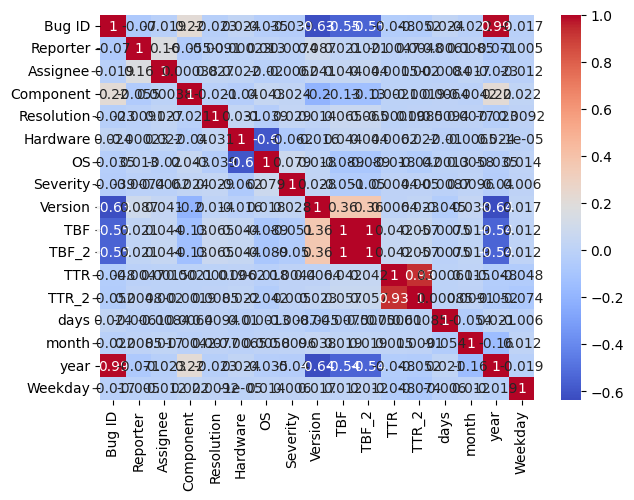

In [ ]:
# 相関行列の計算
corr_matrix = data_set.corr()

# 相関ヒートマップの描画
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### pandas-profiling

In [ ]:
# データの可視化
from pandas_profiling import ProfileReport

profile = ProfileReport(data_set, title='OpenStack', explorative=True)

profile.to_file(output_file='drive/MyDrive/見原/report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/pandas/correlations_pandas.py:84: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  return _cramers_corrected_stat(pd.crosstab(col_1, col_2), correction=True)
/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an axis with duplicate labels')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from IPython.display import display, HTML

# HTMLレポートを表示
display(HTML(filename='drive/MyDrive/見原/report.html'))

Output hidden; open in https://colab.research.google.com to view.

### EDA（探索的データ分析）

In [ ]:
data_set.head(3)

,Bug ID,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,TBF,TBF_2,TTR,TTR_2,days,month,year,Weekday
Opened,,,,,,,,,,,,,,,,,
2012-06-26 09:27:15,835466,0,0,32,1,6,1,0,0,372,8945,6.0,165.0,26,6,2012,5
2012-07-22 13:41:36,842136,0,0,32,5,1,4,2,0,2605,62522,26.0,628.0,22,7,2012,3
2012-08-13 14:36:41,847785,0,0,39,5,1,4,0,0,1352,32450,22.0,528.0,13,8,2012,1


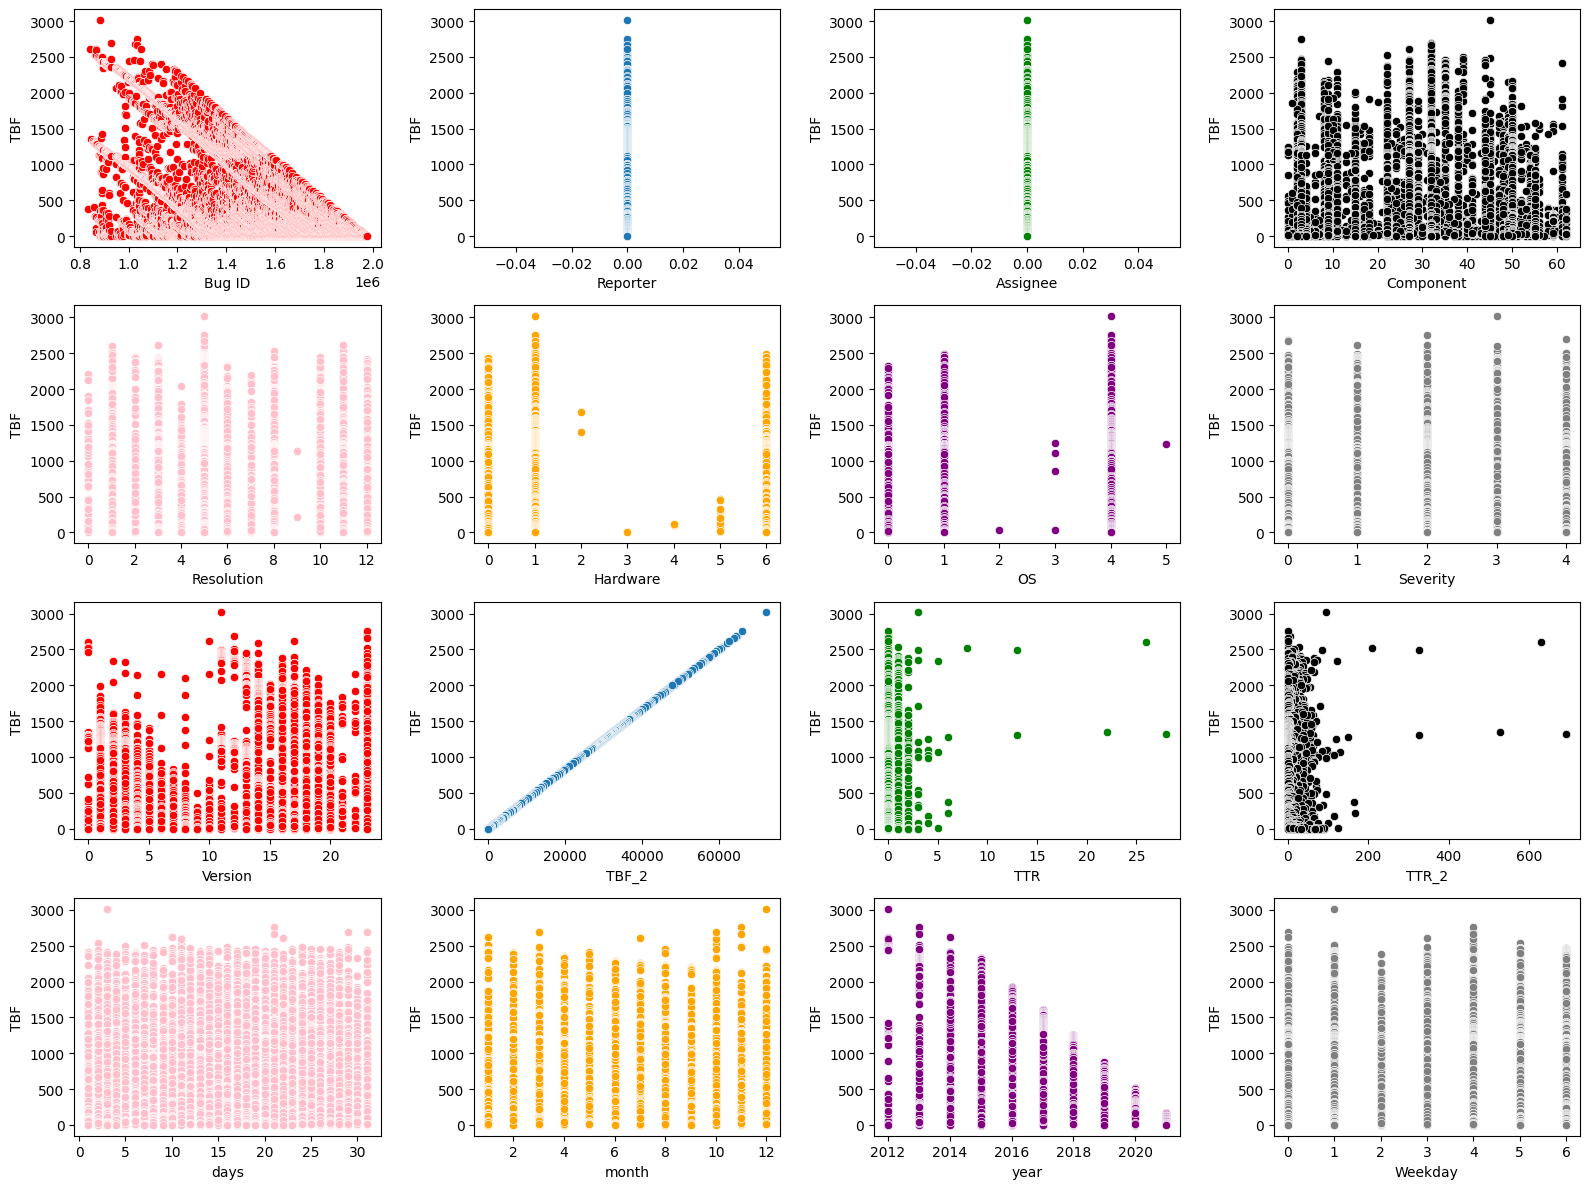

In [ ]:
#可視化
fig, ax = plt.subplots(4,4,figsize=(16,12))
sns.scatterplot(x="Bug ID",y="TBF",data=data_set,ax=ax[0][0],color="red")
sns.scatterplot(x="Reporter",y="TBF",data=data_set,ax=ax[0][1])
sns.scatterplot(x="Assignee",y="TBF",data=data_set,ax=ax[0][2],color="green")
sns.scatterplot(x="Component",y="TBF",data=data_set,ax=ax[0][3],color="Black")
sns.scatterplot(x="Resolution",y="TBF",data=data_set,ax=ax[1][0],color="Pink")
sns.scatterplot(x="Hardware",y="TBF",data=data_set,ax=ax[1][1],color="Orange")
sns.scatterplot(x="OS",y="TBF",data=data_set,ax=ax[1][2],color="Purple")
sns.scatterplot(x="Severity",y="TBF",data=data_set,ax=ax[1][3],color="Grey")
sns.scatterplot(x="Version",y="TBF",data=data_set,ax=ax[2][0],color="red")
sns.scatterplot(x="TBF_2",y="TBF",data=data_set,ax=ax[2][1])
sns.scatterplot(x="TTR",y="TBF",data=data_set,ax=ax[2][2],color="green")
sns.scatterplot(x="TTR_2",y="TBF",data=data_set,ax=ax[2][3],color="Black")
sns.scatterplot(x="days",y="TBF",data=data_set,ax=ax[3][0],color="Pink")
sns.scatterplot(x="month",y="TBF",data=data_set,ax=ax[3][1],color="Orange")
sns.scatterplot(x="year",y="TBF",data=data_set,ax=ax[3][2],color="Purple")
sns.scatterplot(x="Weekday",y="TBF",data=data_set,ax=ax[3][3],color="Grey")
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm

# Dataをインデックスに設定
time_series = data_set.copy()
time_series

,Bug ID,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,TBF,TBF_2,TTR,TTR_2,days,month,year
Opened,,,,,,,,,,,,,,,,
2012-06-26 09:27:15,835466,235,8,32,1,6,1,0,0,372,8945,6.0,165.0,26,6,2012
2012-07-22 13:41:36,842136,235,38,32,5,1,4,2,0,2605,62522,26.0,628.0,22,7,2012
2012-08-13 14:36:41,847785,332,8,39,5,1,4,0,0,1352,32450,22.0,528.0,13,8,2012
2012-09-11 10:20:48,856149,208,261,39,1,1,4,2,11,1323,31757,28.0,691.0,11,9,2012
2012-09-11 15:03:44,856263,208,70,32,5,1,4,3,11,1323,31759,0.0,4.0,11,9,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16 19:36:17,1972877,69,0,32,11,1,4,3,8,5,142,0.0,4.0,16,6,2021
2021-06-17 08:31:28,1973073,1079,207,2,8,1,4,0,4,8,198,0.0,12.0,17,6,2021
2021-06-18 10:53:34,1973635,0,0,32,3,6,1,2,8,0,1,1.0,26.0,18,6,2021


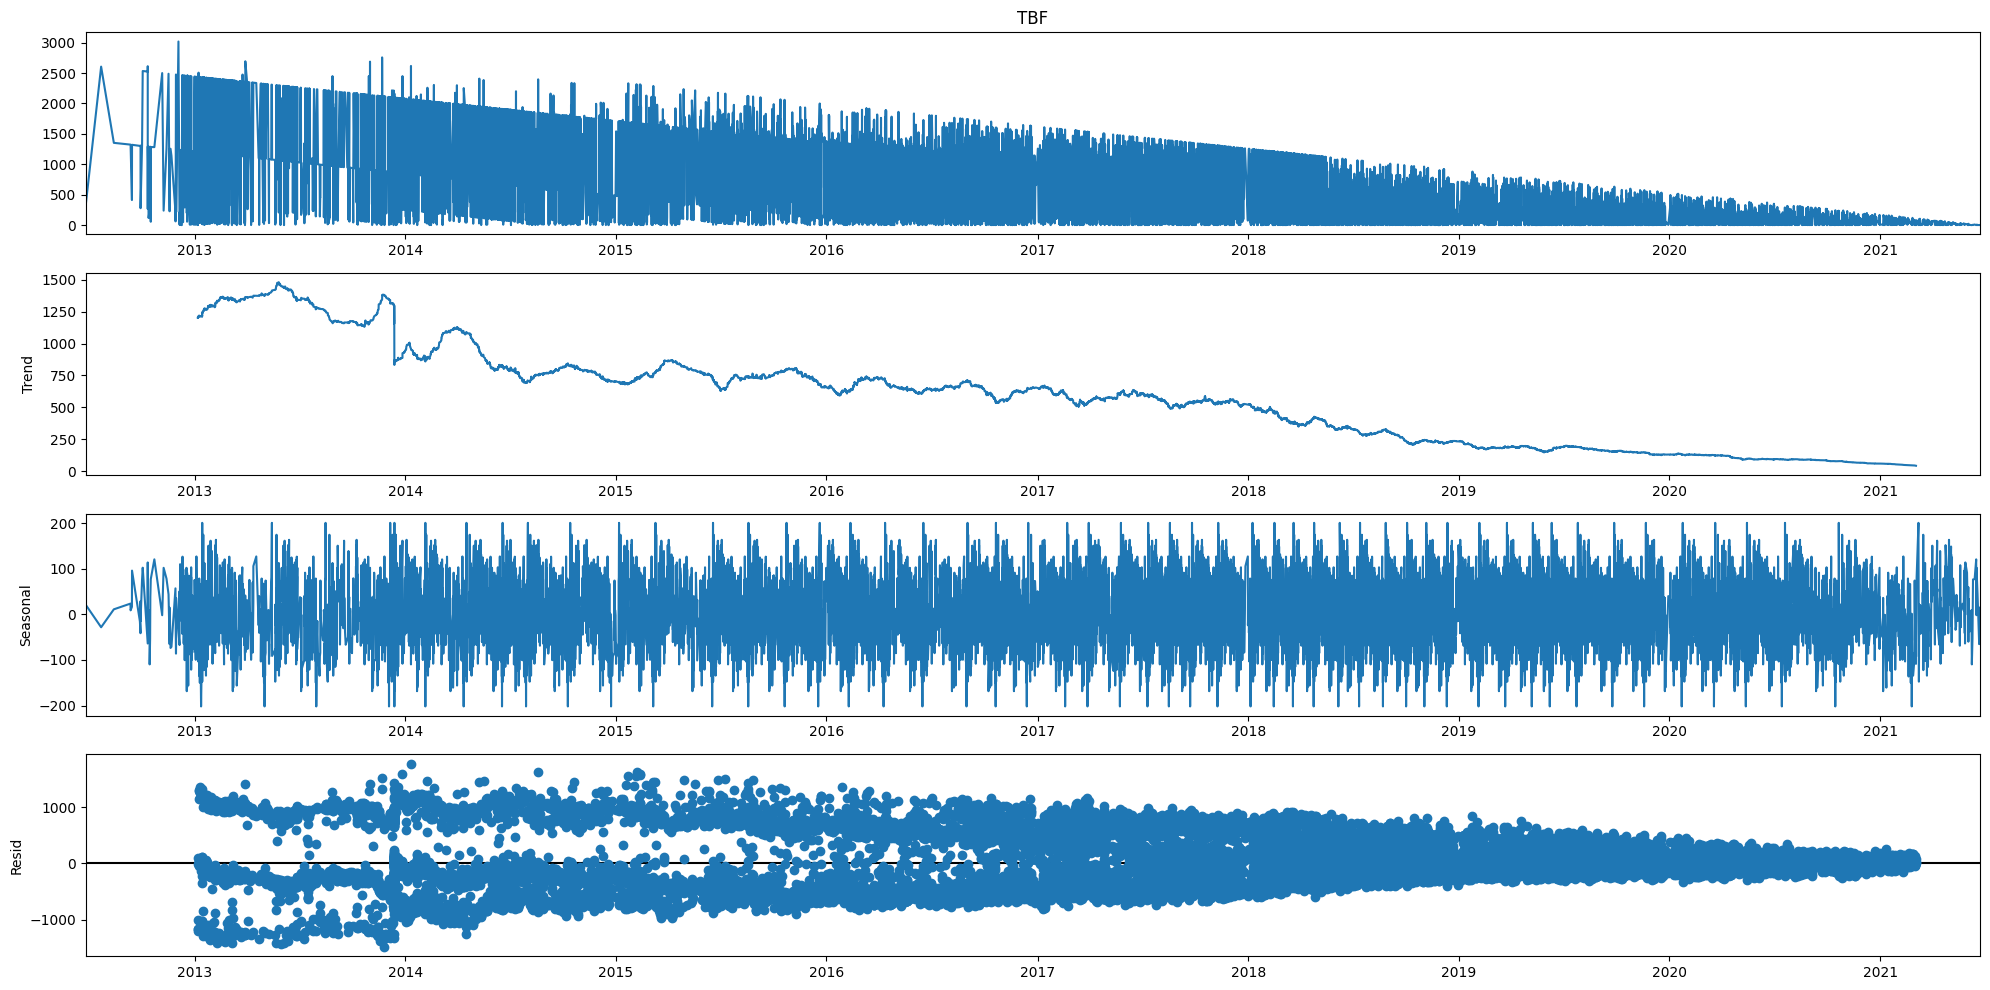

In [ ]:
# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,10]
plt.rcParams["font.size"] = 10

# 原系列、傾向（トレンド）、季節変動（季節性）、不規則変動（残差）
def plt_seasonal_decompose(df, col_name, period):
    res = sm.tsa.seasonal_decompose(df[col_name], period=period)
    fig = res.plot()
    plt.show()

# 原系列をインプットして確認
plt_seasonal_decompose(time_series, col_name='TBF', period=365)

# 以下機械学習

In [16]:
data_set.head(0)

,Bug ID,Reporter,Assignee,Component,Resolution,Hardware,OS,Severity,Version,TBF,TBF_2,TTR,TTR_2,days,month,year,Weekday
Opened,,,,,,,,,,,,,,,,,


In [17]:
#ランダムシード固定
from sklearn.utils import check_random_state
import random
seed = 13
random_state = check_random_state(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [18]:
#説明変数
x = pd.DataFrame(data_set.drop(["TBF","TBF_2","Reporter","Assignee","OS","TTR_2","days","Weekday"],axis=1))# .drop(["hogehoge"]で、"hogehoge"をドロップしてる

#目的変数
y = pd.DataFrame(data_set["TBF"])# ["hogehoge"]のカラムを"y"に代入

#説明変数・目的変数をそれぞれ訓練データ・テストデータに分割（ランダム），シャッフルしない場合は引数（shuffle=False）
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1, shuffle=True, random_state=random_state)

In [19]:
import lightgbm as lgb
import xgboost as xgb

lgb_model = lgb.LGBMRegressor(random_state=random_state)
lgb_model.fit(x_train, y_train)
y_pred2 = lgb_model.predict(x_test)

xgb_model = xgb.XGBRegressor(seed=seed)
xgb_model.fit(x_train, y_train)
y_pred3 = xgb_model.predict(x_test)

In [21]:
from sklearn.metrics import mean_squared_error
print("LightGBM predictions:",np.sqrt(mean_squared_error(y_test, y_pred2)))
print("XGBoost predictions:",np.sqrt(mean_squared_error(y_test, y_pred3)))

LightGBM predictions: 335.98819354022004
XGBoost predictions: 339.44442876250713


In [22]:
# データを標準化
stdsc = StandardScaler()
x_train = stdsc.fit_transform(x_train)
x_test = stdsc.transform(x_test)


# 以下変な処理しているからコメントアウトした（フツーしない）

#データの整形
#x_train = x_train.astype(np.float)
#x_test = x_test.astype(np.float)

#カテゴリデータの場合
#y_train = keras.utils.to_categorical(y_train,10)
#y_test = keras.utils.to_categorical(y_test,10)
#数値データの場合
#y_train = np.array(y_train, dtype = np.float32)
#y_test = np.array(y_test, dtype = np.float32)

In [23]:
#Optimizerの定義
sgd = tf.keras.optimizers.SGD(
        learning_rate=0.1, # 学習率
        weight_decay=0.01,
        momentum=0.9, # momentumのβの値([0-1])。デフォルトは0なので、momentumは無効
        nesterov=False # nesterovを適用するかどうか。デフォルトは無効
        )

rmspropp = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False
)

Adam = tf.keras.optimizers.Adam(learning_rate=0.01)


In [ ]:
#ディープニューラルネットワークの実装1 (activation='relu')
import keras
from tensorflow.keras.layers import BatchNormalization

model = tf.keras.models.Sequential()

t1 = time.time() 

# 結合層(13ユニット->50ユニット)：入力次元を省略すると自動的に前の層の出力次元数を引き継ぐ
# reluやsigmoidがある
model.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(x.shape[1],), kernel_regularizer=keras.regularizers.l1_l2(l1=0.00, l2=0.01))) #L2正則化
model.add(tf.keras.layers.Dropout(0.1))

model.add(BatchNormalization()) #バッチ正規化

model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

#Dropoutを緩めていくと良い（調整の際のコツ）

#目的変数がカテゴリデータの場合（10種類の場合）
#model.add(Dense(10, activation='softmax'))
#目的変数が数値データの場合（出力層．次元1，つまり一つの値を出力する．）
model.add(tf.keras.layers.Dense(1))

model.summary()
print("\n")

#ディープニューラルネットワークの実装2
model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mae'])
#勾配法には、'adam'や'sgd'という方法もある
#metrics=['accuracy']
#metrics=['mae']

#ディープニューラルネットワークの学習
#history = model.fit(x_train, y_train, batch_size=100, epochs=1000, verbose=1, validation_data=(x_test, y_test))
history = model.fit(x_train, y_train, batch_size=16, epochs=200, verbose=1, validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               1000      
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 300)               30300     
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_8 (Dense)             (None, 500)               150500    
                                                      

In [ ]:
#元のコード

"""
#ディープニューラルネットワークの実装1 (activation='relu')
model = tf.keras.models.Sequential()

t1 = time.time() 

# 結合層(13ユニット->50ユニット)：入力次元を省略すると自動的に前の層の出力次元数を引き継ぐ
# reluやsigmoidがある
model.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(13,)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

#Dropoutを緩めていくと良い（調整の際のコツ）

#目的変数がカテゴリデータの場合（10種類の場合）
#model.add(Dense(10, activation='softmax'))
#目的変数が数値データの場合（出力層．次元1，つまり一つの値を出力する．）
model.add(tf.keras.layers.Dense(1))

model.summary()
print("\n")

#ディープニューラルネットワークの実装2
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
#勾配法には、'adam'や'sgd'という方法もある
#metrics=['accuracy']
#metrics=['mae']

#ディープニューラルネットワークの学習
#history = model.fit(x_train, y_train, batch_size=100, epochs=1000, verbose=1, validation_data=(x_test, y_test))
history = model.fit(x_train, y_train, batch_size=100, epochs=100, verbose=1, validation_data=(x_test, y_test))
"""

In [ ]:
"""
#ディープニューラルネットワークの実装1 (activation='relu')
model = tf.keras.models.Sequential()

t1 = time.time() 

# 結合層(13ユニット->50ユニット)：入力次元を省略すると自動的に前の層の出力次元数を引き継ぐ
# reluやsigmoidがある
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(15,)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

#Dropoutを緩めていくと良い（調整の際のコツ）

#目的変数がカテゴリデータの場合（10種類の場合）
#model.add(Dense(10, activation='softmax'))
#目的変数が数値データの場合（出力層．次元1，つまり一つの値を出力する．）
model.add(tf.keras.layers.Dense(1))

model.summary()
print("\n")

#ディープニューラルネットワークの実装2
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='sgd', metrics=['accuracy'])
#勾配法には、'adam'や'sgd'という方法もある
#metrics=['accuracy']
#metrics=['mae']

#ディープニューラルネットワークの学習
#history = model.fit(x_train, y_train, batch_size=100, epochs=1000, verbose=1, validation_data=(x_test, y_test))
history = model.fit(x_train, y_train, batch_size=16, epochs=10, verbose=1, validation_data=(x_test, y_test)) #verboseは表示するエポック頻度

"""

In [ ]:
#ディープニューラルネットワークの推論
score = model.evaluate(x_test, y_test, verbose=1)
print("\n")
print("Test Loss:",score[0])
print("Test MSE:",score[1])

119/119 [==============================] - 0s 2ms/step - loss: 262.3549 - mae: 261.0049


Test Loss: 262.3548583984375
Test MSE: 261.0048828125


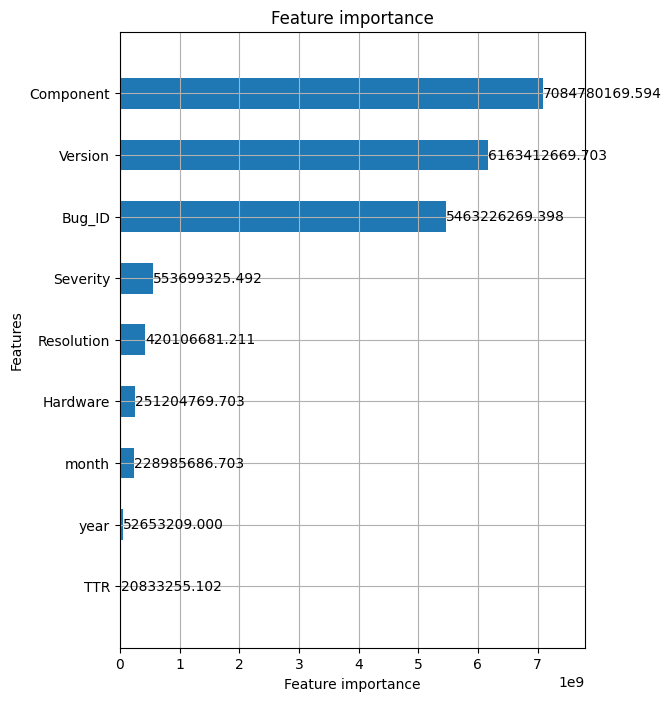

In [ ]:
# 特徴量の重要度
lgb.plot_importance(lgb_model, height = 0.5, figsize = (6,8), importance_type='gain')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(-1)

60/60 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

# SVMの学習と予測
#svm_model = SVC(random_state=random_state)
#svm_model.fit(x_train, y_train)
#svm_predictions = svm_model.predict(x_test)

# ランダムフォレストの学習と予測
rf_model = RandomForestRegressor(random_state=random_state)
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)

# リッジ回帰の学習と予測
ridge_model = Ridge(random_state=random_state)
ridge_model.fit(x_train, y_train)
ridge_predictions = ridge_model.predict(x_test)

# ラッソ回帰の学習と予測
lasso_model = Lasso(random_state=random_state)
lasso_model.fit(x_train, y_train)
lasso_predictions = lasso_model.predict(x_test)

<ipython-input-616-526be8931a27>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e+09, tolerance: 6.181e+05
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.metrics import mean_squared_error
# 結果の表示
print("DNN predictions:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("LightGBM predictions:",np.sqrt(mean_squared_error(y_test, y_pred2)))
print("XGBoost predictions:",np.sqrt(mean_squared_error(y_test, y_pred3)))
#print("SVR predictions:",np.sqrt(mean_squared_error(y_test, svm_predictions)))
print("Random Forest predictions:",np.sqrt(mean_squared_error(y_test, rf_predictions)))
print("Ridge Regression predictions:", np.sqrt(mean_squared_error(y_test, ridge_predictions)))
print("Lasso Regression predictions:", np.sqrt(mean_squared_error(y_test, lasso_predictions)))

DNN predictions: 4467504.677551666
LightGBM predictions: 335.98819354022004
XGBoost predictions: 339.44442876250713
Random Forest predictions: 336.8270774865469
Ridge Regression predictions: 485.60322612854105
Lasso Regression predictions: 487.0948947660803


In [ ]:
#xgboost や　LightGBM　の予測形式に合わせている

ridge_predictions = ridge_predictions.flatten()

In [ ]:
# 加重平均の重み
weights = [0.0, 0.38, 0.2, 0.45, 0.0, 0.0]

# 予測結果の加重平均（ブレンディング）
y_pred4 = np.average([y_pred, y_pred2, y_pred3, rf_predictions, ridge_predictions, lasso_predictions], axis=0, weights=weights)

print(np.sqrt(mean_squared_error(y_test, y_pred4)))

327.0661011384621


In [ ]:
# 図の大きさ調整
plt.rcParams["figure.figsize"] = [7,5]

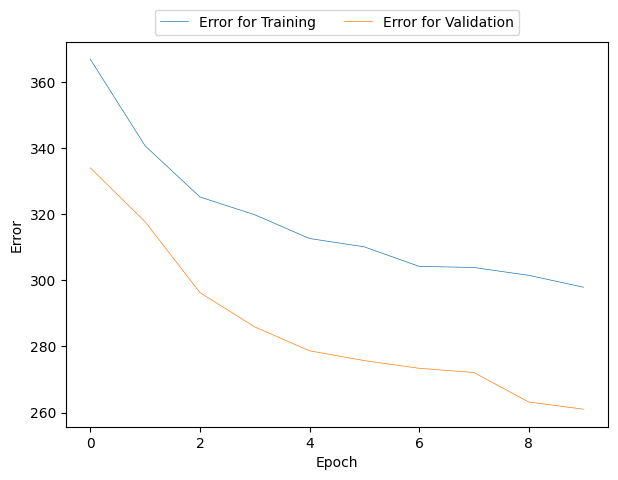

In [ ]:
# 精度の履歴をプロット
# 分類問題のAccuracyは，(True Positive+True Negative)/(True Positive+True Negative+False Positive+False Negative)のようなものを表す．
# 回帰の場合は誤差を最小化するのでmseを使うだけで良い．観測値と予測値の差異を数値化したものを表す．
plt.plot(history.history['mae'], label="Error for Training", lw=0.5)
plt.plot(history.history['val_mae'], label="Error for Validation", lw=0.5)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3)
plt.show()
#plt.savefig("error.eps")
#plt.close()

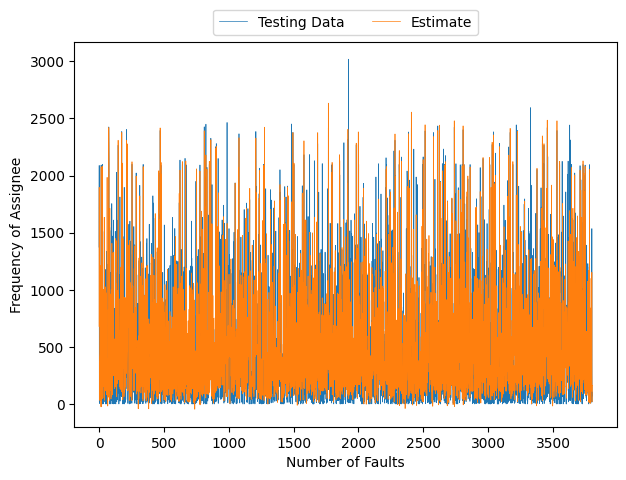

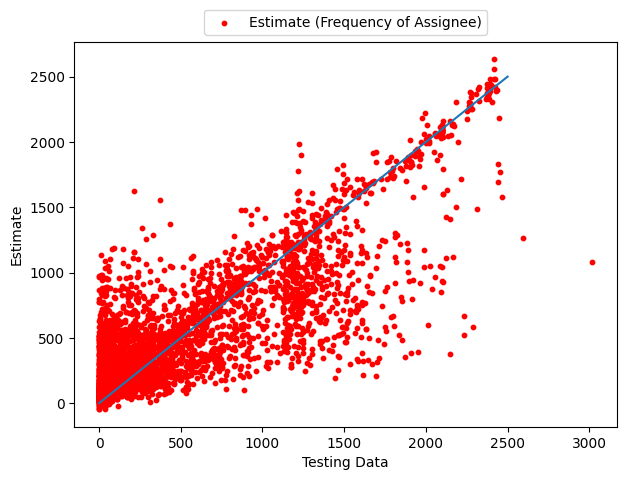

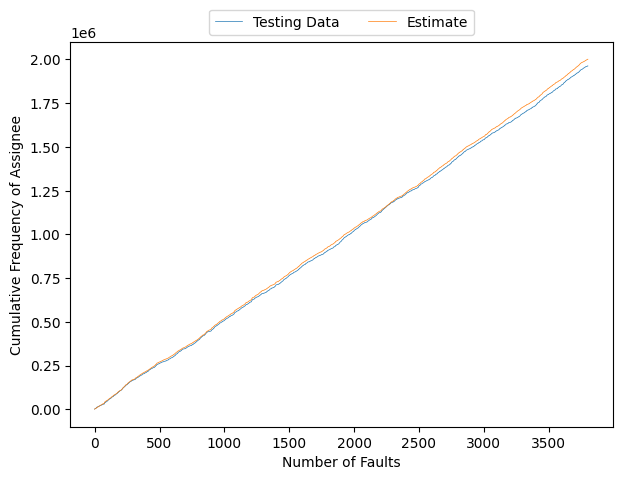

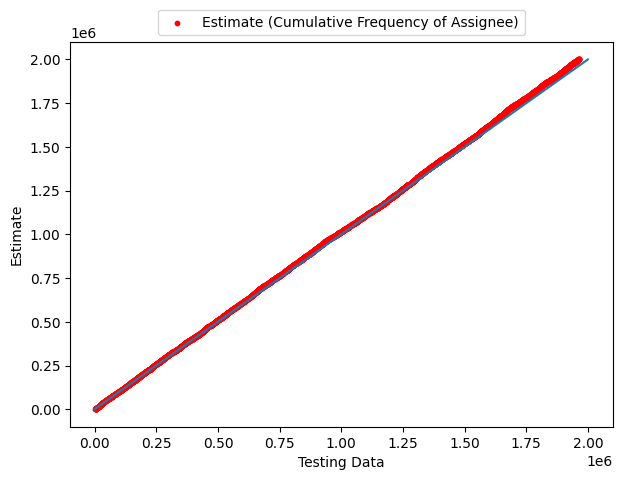

In [ ]:
# テストデータに対する推定結果のプロット
plt.plot(y_test, lw=0.5)
plt.plot(y_pred4, lw=0.5)
plt.xlabel('Number of Faults')
plt.ylabel('Frequency of Assignee')
plt.legend(['Testing Data', 'Estimate'], loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3)
plt.show()
#plt.savefig("drive/MyDrive/見原/frequency.jpg")
#plt.close()

# テストデータに対する推定結果の散布図
plt.scatter(y_test, y_pred4, c='r', s=10)
plt.xlabel('Testing Data')
plt.ylabel('Estimate')
plt.legend(['Estimate (Frequency of Assignee)'], loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3)
plt.plot([0,2500],[0,2500])
plt.show()
#plt.savefig("drive/MyDrive/見原/general_scatter.jpg")
#plt.close()

# テストデータに対する推定された累積時間データのプロット
plt.plot(np.cumsum(y_test), lw=0.5)
plt.plot(np.cumsum(y_pred4), lw=0.5)
plt.xlabel('Number of Faults')
plt.ylabel('Cumulative Frequency of Assignee')
plt.legend(['Testing Data', 'Estimate'], loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3)
plt.show()
#plt.savefig("drive/MyDrive/見原/cfrequency.jpg")
#plt.close()

# テストデータに対する累積時間データの散布図
plt.scatter(np.cumsum(y_test), np.cumsum(y_pred4), c='r', s=10)
plt.xlabel('Testing Data')
plt.ylabel('Estimate')
plt.legend(['Estimate (Cumulative Frequency of Assignee)'], loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3)
plt.plot([0,2000000],[0,2000000])
plt.show()
#plt.savefig("drive/MyDrive/見原/cscatter.jpg")
#plt.close()